# Import

In [10]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

# Constants and configuration

In [11]:
DATA_DIR = "datasets"

# Hyperparameters
IMG_SIZE = 128
BATCH_SIZE = 32
VAL_SPLIT = 0.2 # 20% for validation

# Transformations and dataset preparation

In [12]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet stats (good default)
        std=[0.229, 0.224, 0.225]
    ),
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet stats (good default)
        std=[0.229, 0.224, 0.225]
    ),
])

In [13]:
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=train_transforms)

# Class names and mapping (folder names => indices)
class_names = full_dataset.classes      # ['paper', 'rock', 'scissors']
class_to_idx = full_dataset.class_to_idx    # {'paper': 0, 'rock': 1, 'scissors': 2}
print("Classes", class_names)

Classes ['paper', 'rock', 'scissors']


In [14]:
n_total = len(full_dataset)
n_val = int(n_total * VAL_SPLIT)
n_train = n_total - n_val

train_dataset, val_dataset = random_split(full_dataset, [n_train, n_val])

# For validation, we don't need data augmentation
val_dataset.dataset.transform = val_transforms

# Data loaders

In [15]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Show datasets

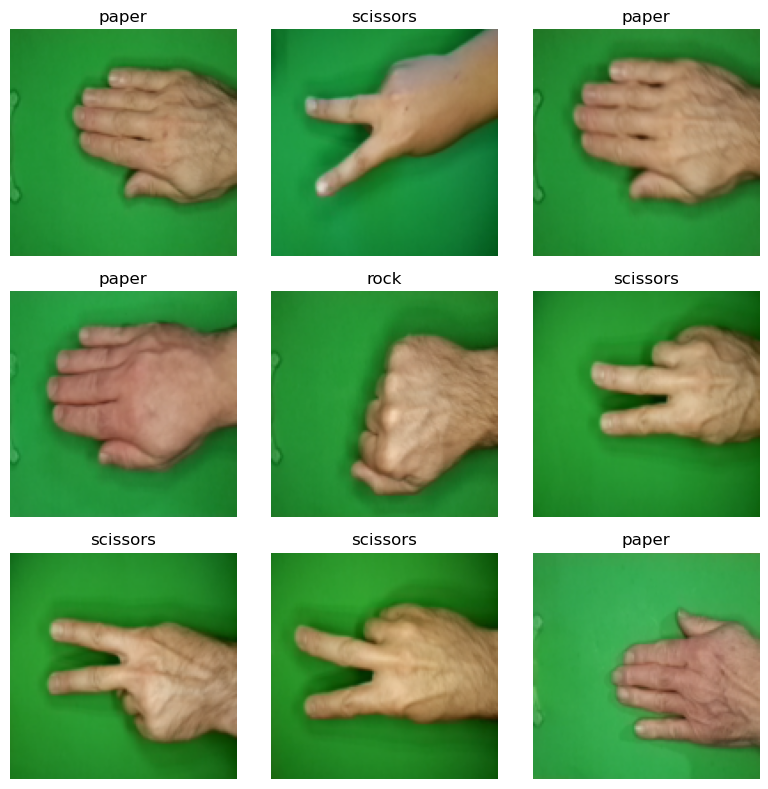

In [16]:
# Helper to undo normalization for visualization
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img = img_tensor.numpy().transpose((1, 2, 0))  # C,H,W -> H,W,C
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Get one batch
images, labels = next(iter(train_loader))

NUM_IMG = 9
plt.figure(figsize=(8, 8))

for i in range(NUM_IMG):
    ax = plt.subplot(3, 3, i + 1)
    img = denormalize(images[i])
    plt.imshow(img)
    label_idx = labels[i].item()
    plt.title(class_names[label_idx])
    plt.axis("off")

plt.tight_layout()
plt.show()

# Define model

In [17]:
NUM_CLASSES = len(class_names)

class RockPaperScissorsCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        # 3 x 128 x 128 -> conv blocks -> flatten -> FC
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # 3 -> 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2) # 128 -> 64
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # 32 -> 64
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2), # 64 -> 32
            nn.Dropout(0.25)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),    # 64 -> 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2) # 32 -> 16
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),    # 128 -> 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            nn.MaxPool2d(2), # 16 -> 8
            nn.Dropout(0.25)
        )

        # After 3 poolings : 3 x 128 x 128 -> 256 x 8 x 8
        self.flatten_dim = 256 * 8 * 8

        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes) # logits for each class
        )
    
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = x.view(x.size(0), -1)   # flatten
        x = self.fc(x)
        return x

# Instantiate model
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RockPaperScissorsCNN().to(DEVICE)
model


RockPaperScissorsCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_bl

# Model training

In [18]:
# Training configuration
EPOCHS = 30
LEARNING_RATE = 1e-3
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

best_val_loss = float("inf")
BEST_MODEL_PATH = "models/model.pt"

for epoch in range(1, EPOCHS + 1):
    # ---- TRAIN ----
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch} / {EPOCHS} [Train]", leave=False)
    
    for images, labels in train_pbar:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / total
    train_acc = correct / total

    # ---- VALIDATION ----
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    val_pbar = tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [Val]", leave=False)
    with torch.no_grad():
        for images, labels in val_pbar:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total

    # ---- Save the best model (lowest validation loss) ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        saved_flag = " [saved best]"
    else:
        saved_flag = ""
    
    print(
        f"Epoch {epoch:02d} / {EPOCHS} "
        f"- train loss: {train_loss:.4f}, train_acc: {train_acc:.4f} "
        f"- val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f} {saved_flag}"
    )

print(f"\nBest validation loss: {best_val_loss:.4f}")

Epoch 1 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 01 / 30 - train loss: 1.6929, train_acc: 0.7167 - val_loss: 0.2244, val_acc: 0.9291  [saved best]


Epoch 2 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 02 / 30 - train loss: 0.1498, train_acc: 0.9503 - val_loss: 0.0984, val_acc: 0.9565  [saved best]


Epoch 3 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 03 / 30 - train loss: 0.1047, train_acc: 0.9703 - val_loss: 0.0655, val_acc: 0.9748  [saved best]


Epoch 4 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 04 / 30 - train loss: 0.0509, train_acc: 0.9840 - val_loss: 0.0547, val_acc: 0.9748  [saved best]


Epoch 5 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 5/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 05 / 30 - train loss: 0.0652, train_acc: 0.9806 - val_loss: 0.0372, val_acc: 0.9817  [saved best]


Epoch 6 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 6/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 06 / 30 - train loss: 0.0412, train_acc: 0.9891 - val_loss: 0.0300, val_acc: 0.9954  [saved best]


Epoch 7 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 7/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 07 / 30 - train loss: 0.0342, train_acc: 0.9909 - val_loss: 0.0449, val_acc: 0.9748 


Epoch 8 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 8/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 08 / 30 - train loss: 0.0210, train_acc: 0.9920 - val_loss: 0.0666, val_acc: 0.9703 


Epoch 9 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 9/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 09 / 30 - train loss: 0.0372, train_acc: 0.9880 - val_loss: 0.0343, val_acc: 0.9863 


Epoch 10 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 10/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10 / 30 - train loss: 0.0338, train_acc: 0.9880 - val_loss: 0.0229, val_acc: 0.9931  [saved best]


Epoch 11 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 11/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11 / 30 - train loss: 0.0121, train_acc: 0.9954 - val_loss: 0.0182, val_acc: 0.9908  [saved best]


Epoch 12 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 12/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12 / 30 - train loss: 0.0215, train_acc: 0.9903 - val_loss: 0.0845, val_acc: 0.9725 


Epoch 13 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 13/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13 / 30 - train loss: 0.0358, train_acc: 0.9903 - val_loss: 0.0291, val_acc: 0.9886 


Epoch 14 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 14/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14 / 30 - train loss: 0.0293, train_acc: 0.9909 - val_loss: 0.0858, val_acc: 0.9748 


Epoch 15 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 15/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15 / 30 - train loss: 0.0242, train_acc: 0.9909 - val_loss: 0.0530, val_acc: 0.9886 


Epoch 16 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 16/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16 / 30 - train loss: 0.0092, train_acc: 0.9960 - val_loss: 0.0233, val_acc: 0.9931 


Epoch 17 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 17/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17 / 30 - train loss: 0.0158, train_acc: 0.9949 - val_loss: 0.0739, val_acc: 0.9771 


Epoch 18 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 18/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18 / 30 - train loss: 0.0183, train_acc: 0.9926 - val_loss: 0.0259, val_acc: 0.9908 


Epoch 19 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 19/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19 / 30 - train loss: 0.0139, train_acc: 0.9943 - val_loss: 0.0201, val_acc: 0.9908 


Epoch 20 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 20/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20 / 30 - train loss: 0.0197, train_acc: 0.9966 - val_loss: 0.0244, val_acc: 0.9886 


Epoch 21 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 21/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 21 / 30 - train loss: 0.0208, train_acc: 0.9926 - val_loss: 0.0386, val_acc: 0.9886 


Epoch 22 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 22/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 22 / 30 - train loss: 0.0212, train_acc: 0.9937 - val_loss: 0.0745, val_acc: 0.9771 


Epoch 23 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 23/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 23 / 30 - train loss: 0.0195, train_acc: 0.9931 - val_loss: 0.0270, val_acc: 0.9931 


Epoch 24 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 24/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 24 / 30 - train loss: 0.0131, train_acc: 0.9954 - val_loss: 0.0150, val_acc: 0.9977  [saved best]


Epoch 25 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 25/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 25 / 30 - train loss: 0.0151, train_acc: 0.9937 - val_loss: 0.0366, val_acc: 0.9863 


Epoch 26 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 26/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 26 / 30 - train loss: 0.0058, train_acc: 0.9977 - val_loss: 0.0598, val_acc: 0.9863 


Epoch 27 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 27/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 27 / 30 - train loss: 0.0288, train_acc: 0.9920 - val_loss: 0.3400, val_acc: 0.9291 


Epoch 28 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 28/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 28 / 30 - train loss: 0.0173, train_acc: 0.9937 - val_loss: 0.0447, val_acc: 0.9908 


Epoch 29 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 29/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 29 / 30 - train loss: 0.0191, train_acc: 0.9943 - val_loss: 0.0753, val_acc: 0.9863 


Epoch 30 / 30 [Train]:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 30/30 [Val]:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 30 / 30 - train loss: 0.0301, train_acc: 0.9920 - val_loss: 0.0270, val_acc: 0.9863 

Best validation loss: 0.0150
